# Importing required libraries

In [1]:
# pip install numpy;
# pip install pandas;
# pip install matplotlib
# pip install tensorflow
# pip install pydot
# pip install mlxtend
# pip install opencv-python
# pip install nbconvert

In [92]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import cv2 as cv
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split



# Directories of training , testing & validation data

In [74]:
input_data="chest_Xray/"
train_directory= input_data + "train/"
val_directory= input_data + "val/"
test_directory= input_data + "test/"

# Getting the class names

In [75]:
data_dir = train_directory
class_names=os.listdir(train_directory)
print(class_names)

['NORMAL', 'PNEUMONIA']


# Define Constantes

In [110]:
# dir to generate files
FILES_GENERATED = 'files_generated/'
# name of model to save to png file
MODEL_PNG = 'cnn_model.png'
#checkpoint dir
CHECKPOINT_DIR = 'checkpoints/'
# name of best model to save
MODEL_SAVED = 'saved_model/model.h5'
# Default batch size
BATCH_SIZE = 32
# Image size
IMAGE_SIZE = 180

# Function to display random images...

In [6]:
def view_random_image(target_directory, target_class):
    target_folder = target_directory + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    return img

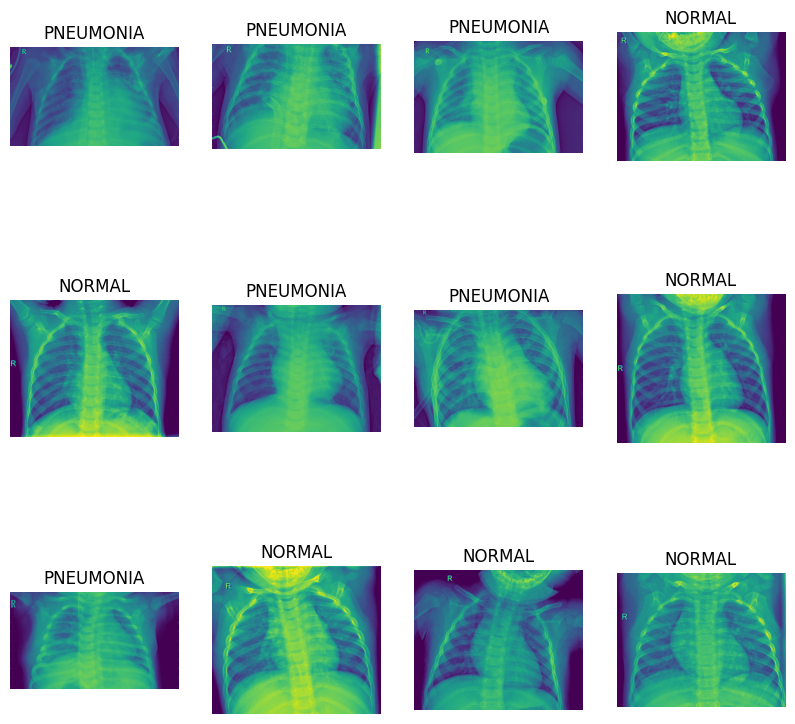

In [7]:
plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    r=random.randint(0,1)
    img = view_random_image(data_dir, class_names[r])   

# Random vizualization from all directories

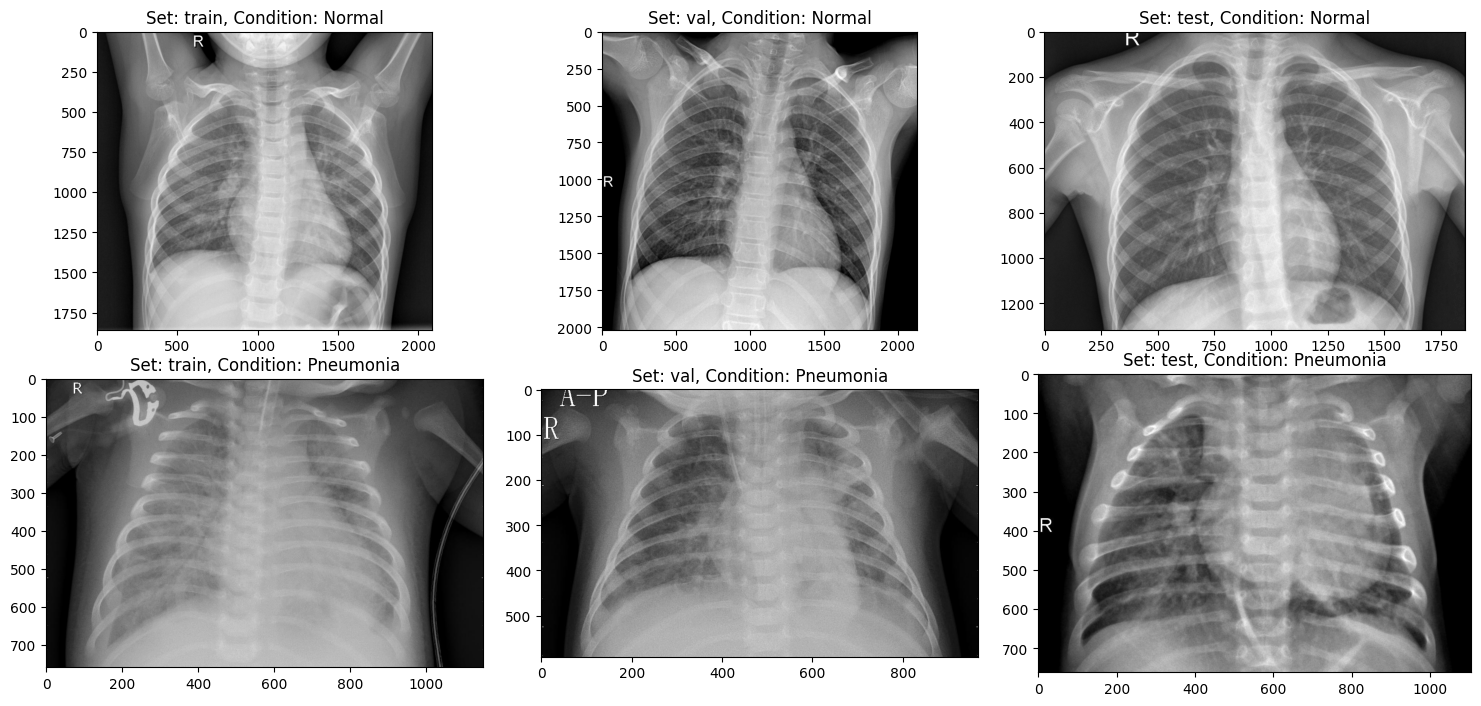

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_data + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

# No. of images present in each set

In [9]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_data + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_data + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1341, pneumonia images: 3875
Set: val, Normal images: 9, pneumonia images: 8
Set: test, Normal images: 234, pneumonia images: 390


# Keras ImageDataGenerator

<p> It is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed. It does not add the data. Keras image data generator class is also used to carry out data augmentation where we aim to gain the overall increment in the generalization of the model. Operations such as rotations, translations, shearin, scale changes, and horizontal flips are carried out randomly in data augmentation using an image data generator. </p>

![ImageDataGenerator](http://ai.stanford.edu/blog/assets/img/posts/2020-04-20-data-augmentation/fig1.png)

## This is how it looks like
![ImageDataGenerator_sample](https://miro.medium.com/max/1200/1*Ukc49J8TzyxiOD30EqOWwQ.png)


In [111]:
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest',
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255,
)

# Flow from directory

<p> This method is useful when the images are sorted and placed in there respective class/label folders. This method will identify classes automatically from the folder name. </p> 

![Flow from directory](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [112]:
train = Image_gen.flow_from_directory(
    train_directory,
    batch_size=32,
    class_mode='binary',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )

validation = Image_gen.flow_from_directory(
    val_directory,
    batch_size=2,                                              
    class_mode='binary',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )

test = val_Datagen.flow_from_directory(
    test_directory,
    batch_size=2,
    class_mode='binary',     
    target_size=(IMAGE_SIZE, IMAGE_SIZE)                    
    )

Found 5216 images belonging to 2 classes.
Found 17 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [113]:
img, label = next(train)

# Early Stopping 

<p> In machine learning, early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration. Up to a point, this improves the learner's performance on data outside of the training set. Past that point, however, improving the learner's fit to the training data comes at the expense of increased generalization error. Early stopping rules provide guidance as to how many iterations can be run before the learner begins to over-fit. Early stopping rules have been employed in many different machine learning methods, with varying amounts of theoretical foundation. </p>

![Early stopping](https://i.stack.imgur.com/LY2wM.png)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

# ReduceLROnPlateau

<p> Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. </p>

![ReduceLROnPlateau](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr1.png)

In [14]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

# ResNet50V2 model
**Reference**

[MathWorks resnet50](https://www.mathworks.com/help/deeplearning/ref/resnet50.html)

<p> ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database . The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. </p>

![ResNet50](https://www.researchgate.net/publication/363920620/figure/fig2/AS:11431281086998031@1664428512125/Resnet50v2-and-LSTM-based-visual-baseline-models-architecture-The-size-of-the-feature.ppm)

In [15]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [16]:
res_model = create_model()

In [17]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Converts a Keras model to dot format and save to a file.

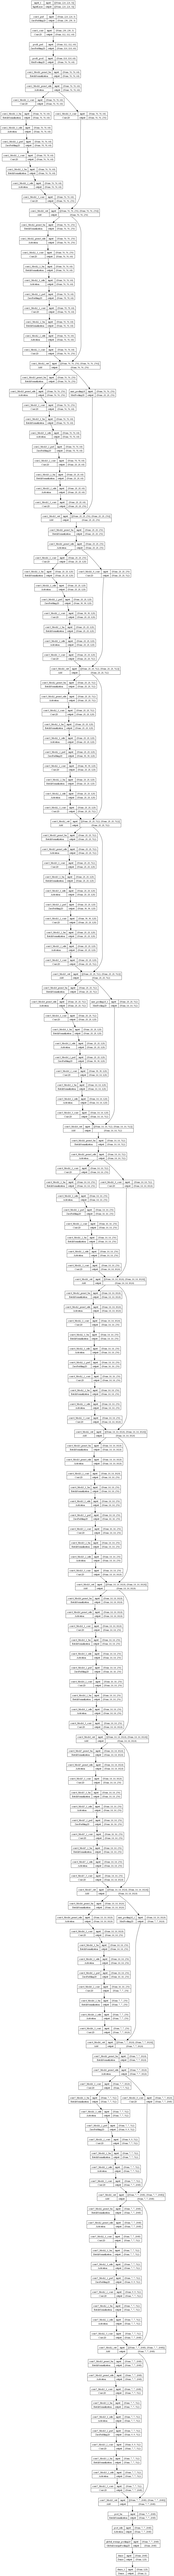

In [18]:
plot_model(res_model, to_file=FILES_GENERATED + MODEL_PNG, show_shapes=True, show_layer_names=True)
display(Image.open(FILES_GENERATED + MODEL_PNG))

# train model

In [19]:
checkpoint_path = CHECKPOINT_DIR + "cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

# Create a callback allowing to save the best performing model
checkpoint = ModelCheckpoint(MODEL_SAVED, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = res_model.fit(train,epochs=30, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr, checkpoint],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8537
Epoch 1: val_loss improved from inf to 0.80012, saving model to saved_model\model.h5
100/100 [==============================] - 131s 1s/step - loss: 0.3233 - accuracy: 0.8537 - val_loss: 0.8001 - val_accuracy: 0.7059 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9137
Epoch 2: val_loss did not improve from 0.80012
100/100 [==============================] - 125s 1s/step - loss: 0.2152 - accuracy: 0.9137 - val_loss: 0.9429 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9256
Epoch 3: val_loss improved from 0.80012 to 0.50200, saving model to saved_model\model.h5
100/100 [==============================] - 125s 1s/step - loss: 0.1885 - accuracy: 0.9256 - val_loss: 0.5020 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - ET

# Accuracy & Loss each epochs

Text(0, 0.5, 'Loss')

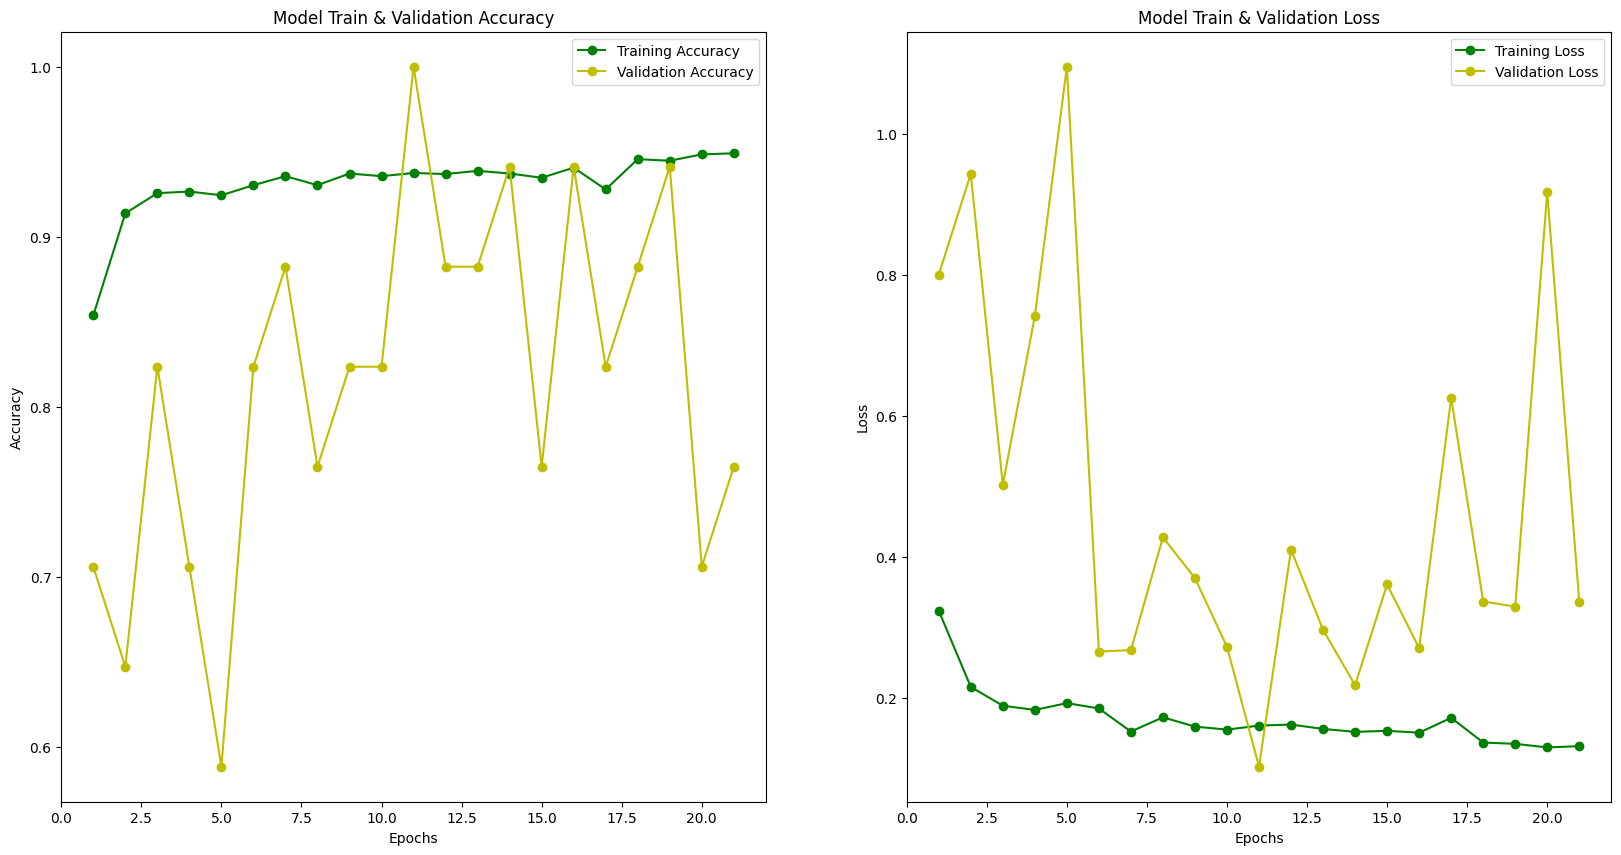

In [20]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

# Model evaluation with training and testing data

In [21]:
# Evaluating the model on train and test
score = res_model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = res_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 186s 1s/step - loss: 0.1238 - accuracy: 0.9519
Train Loss:  0.12377023696899414
Train Accuracy:  0.9518788456916809
312/312 [==============================] - 26s 83ms/step - loss: 0.2332 - accuracy: 0.9167

Test loss:  0.2332271933555603
Test Accuracy:  0.9166666865348816


In [114]:
# Obtain the predicted labels for the test dataset
model = tf.keras.models.load_model(MODEL_SAVED)
test_preds = []
for i in range(len(test)):
    test_batch = test[i]
    batch_preds = model.predict(test_batch[0])
    test_preds.append(np.round(batch_preds).astype(int))
test_preds = np.concatenate(test_preds)

# Obtain the true labels for the test dataset
test_true = test.classes

# Generate the confusion matrix
cm = confusion_matrix(test_true, test_preds)
print(cm)

1/1 [==============================] - 0s 16ms/step


ValueError: Classification metrics can't handle a mix of binary and multiclass-multioutput targets

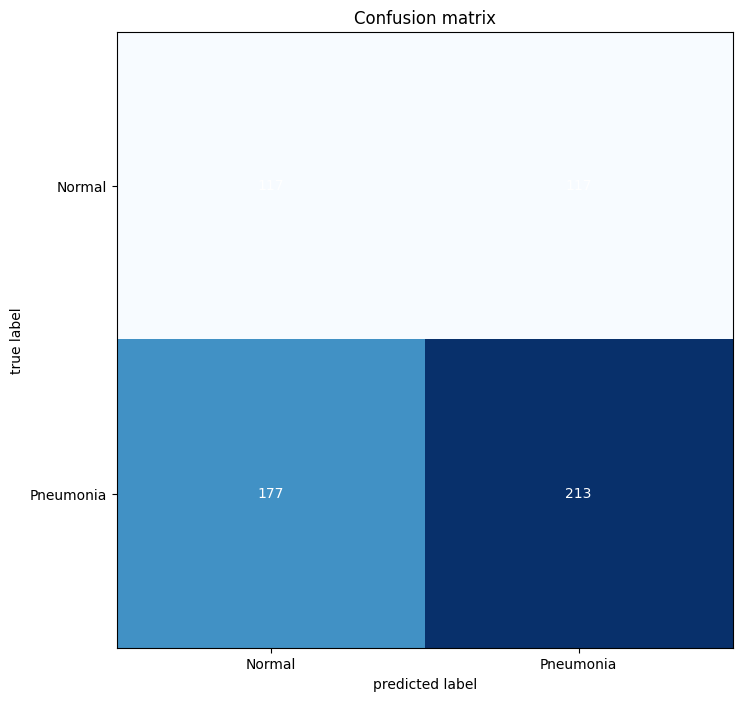

In [107]:
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

In [106]:
def perf_measure(y_test, pred_final):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(pred_final)): 
        if y_test[i]==pred_final[i]==1:
           TP += 1
        if y_test[i]==0 and y_test[i]!=pred_final[i]:
           FP += 1
        if y_test[i]==pred_final[i]==0:
           TN += 1
        if y_test[i]==1 and y_test[i]!=pred_final[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [108]:
tp, fp, tn ,fn = perf_measure(test_true, test_preds)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.55
Precision of the model is 0.65
F-Score is 0.59
